In [1]:
import numpy as np   
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation

d_phi = 0.02
phi_min = -np.pi
phi_max = np.pi
m = 100
g = 0.001
l = 1
phi = np.arange(phi_min, phi_max, d_phi)
print(f"len(phi): {len(phi)}")
print(f"phi_check: {phi[0]} {phi[-1]}")
print(f"1/m: {1/m}")
print(f"mgl: {m*g*l}")


# KE_constant = 0.00001
# PE_constant = 0.1

dt = 0.01
steps = 10000
# gaussian with periodic boundary conditions
# 1.046 is the closest to minimum uncertainty found
kappa = 1.046 * m * np.sqrt(g * l)
phi_0 = 0 
# phi_0 = np.pi / 2
psi_phi = np.exp(kappa * (np.cos(phi-phi_0) - 1))
psi_phi = psi_phi / np.sqrt(np.sum(np.abs(psi_phi)**2) * d_phi)


len(phi): 315
phi_check: -3.141592653589793 3.1384073464102125
1/m: 0.01
mgl: 0.1


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def momentum_operator_periodic(psi, d_phi):
    '''
    Calculate the momentum operator acting on the wavefunction psi with periodic boundary conditions.
    '''
    # create an array to hold the derivative
    d_psi = np.zeros(psi.shape, dtype=complex)
    
    # calculate the derivative
    for i in range(1, len(psi)-1):
        d_psi[i] = (psi[i+1] - psi[i-1]) / (2*d_phi)
    
    # calculate the derivative at the end points
    d_psi[0] = (psi[1] - psi[-1]) / (2 * d_phi)
    d_psi[-1] = (psi[0] - psi[-2]) / (2 * d_phi)
    
    return -1j * d_psi

def pendulum_potential_periodic(phi, m, g, l):
    return m * g * l * (1 - np.cos(phi))

def d_psi_pendulum(psi_phi, phi, d_phi, m=1e5, g=1e-3, l=1):
    # Calculate H_psi
    H_psi = 0.5 * (1/(m * l ** 2)) * momentum_operator_periodic(momentum_operator_periodic(psi_phi, d_phi), d_phi) + pendulum_potential_periodic(phi, m, g, l) * psi_phi
    # The derivative of psi_x is 1j * H_psi
    return -1j * H_psi

def euler_step(psi_phi, phi, d_phi, dt):
    return psi_phi + d_psi_pendulum(psi_phi, phi, d_phi) * dt

def energy(psi_phi, phi, d_phi, m=1e5, g=1e-3, l=1):
    # Calculate H_psi
    H_psi = 0.5 * (1/(m * l ** 2)) * momentum_operator_periodic(momentum_operator_periodic(psi_phi, d_phi), d_phi) + pendulum_potential_periodic(phi, m, g, l) * psi_phi

    return np.sum(np.conj(psi_phi) * H_psi) * d_phi

def phi_expectation(psi_phi, phi, d_phi):
    return np.sum(np.conj(psi_phi) * phi * psi_phi) * d_phi

def rk_step(psi_phi, phi, d_phi, dt, m, g, l):
    k1 = d_psi_pendulum(psi_phi, phi, d_phi, m, g, l)
    k2 = d_psi_pendulum(psi_phi + 0.5 * dt * k1, phi, d_phi, m, g, l)
    k3 = d_psi_pendulum(psi_phi + 0.5 * dt * k2, phi, d_phi, m, g, l)
    k4 = d_psi_pendulum(psi_phi + dt * k3, phi, d_phi, m, g, l)

    return psi_phi + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)

In [3]:

step_frequency = 100
psi_phi_t = np.zeros(shape=(step_frequency, len(psi_phi)), dtype=complex)
phi_expectations = np.zeros(shape=(step_frequency))
energy_t = np.zeros(shape=(step_frequency))
np.save("data/quantum_pendulum/potential.npy", pendulum_potential_periodic(phi, m, g, l))
for i in range(steps):
    psi_phi = rk_step(psi_phi, phi, d_phi, dt, m, g, l)

    if i % int(steps/step_frequency) == 0:
        print(f"i: {i}")
        # record psi_x
        psi_phi_t[int(i/int(steps/step_frequency))] = psi_phi
        phi_expectations[int(i/int(steps/step_frequency))] = np.real(phi_expectation(psi_phi, phi, d_phi))
        energy_t[int(i/int(steps/step_frequency))] = energy(psi_phi, phi, d_phi, m, g, l)
        print(f"Energy: {energy_t[int(i/int(steps/step_frequency))]}")
        print(f"Position Expectation: {phi_expectations[int(i/int(steps/step_frequency))]}")
        np.save("data/quantum_pendulum/psi_phi_t_progress.npy", psi_phi_t)
        np.save("data/quantum_pendulum/energy_t.npy", energy_t)

    # E = energy(psi_phi, d_phi, m, g, l)
    # if np.real(E) > 5:
    #     break

<ipython-input-3-f4b374085324>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_t[int(i/int(steps/step_frequency))] = energy(psi_phi, phi, d_phi, m, g, l)


i: 0
Energy: 0.01551381582075233
Position Expectation: -1.809706745348194e-08
i: 100
Energy: 0.015513815820752331
Position Expectation: -1.8027714219215342e-08
i: 200
Energy: 0.015513815820752326
Position Expectation: -1.7954581146284456e-08
i: 300
Energy: 0.015513815820752326
Position Expectation: -1.7854548524098845e-08
i: 400
Energy: 0.01551381582075233
Position Expectation: -1.7725456338268942e-08
i: 500
Energy: 0.015513815820752326
Position Expectation: -1.7567372445626006e-08
i: 600
Energy: 0.015513815820752326
Position Expectation: -1.738123966532612e-08
i: 700
Energy: 0.015513815820752324
Position Expectation: -1.716851024013977e-08
i: 800
Energy: 0.015513815820752326
Position Expectation: -1.6930986568297612e-08
i: 900
Energy: 0.015513815820752324
Position Expectation: -1.6670724534151304e-08
i: 1000
Energy: 0.015513815820752322
Position Expectation: -1.638996057096165e-08
i: 1100
Energy: 0.015513815820752322
Position Expectation: -1.609104877786649e-08
i: 1200
Energy: 0.01551

In [11]:
print(f"standard deviation: m * sqrt(g * l) = {np.sqrt(1 / (1.046 * m * np.sqrt(g * l)))}")
# calculate the standard deviation in momentum using momentum operator in position basis
expectation_x = np.sum(np.conj(psi_phi) * phi * psi_phi) * d_phi
expectation_x2 = np.sum(np.conj(psi_phi) * phi**2 * psi_phi) * d_phi
std_dev_x = np.sqrt(expectation_x2 - expectation_x**2)
print(f"expectation_x: {expectation_x}")
print(f"expectation_x2: {expectation_x2}")
print(f"std_dev_x: {std_dev_x}")
expectation_p = np.sum(np.conj(psi_phi) * momentum_operator_periodic(psi_phi, d_phi)) * d_phi
expectation_p2 = np.sum(np.conj(psi_phi) * momentum_operator_periodic(momentum_operator_periodic(psi_phi, d_phi), d_phi)) * d_phi 
std_dev_p = np.sqrt(expectation_p2 - expectation_p**2)
print(f"expecation_p: {expectation_p}")
print(f"expecation_p2: {expectation_p2}")
print(f"std_dev_p: {std_dev_p}")

print(f"sigma_x * sigma_p = {np.real(std_dev_x * std_dev_p)}")

standard deviation: m * sqrt(g * l) = 0.5498372486619085
expectation_x: (-1.5321410309354634e-08-1.8819865274188154e-20j)
expectation_x2: (0.1652965419427764-6.75975867912784e-20j)
std_dev_x: (0.40656677427302906-8.31322080964948e-20j)
expecation_p: (2.0257351351915533e-13+0j)
expecation_p2: (1.5185957862409334+0j)
std_dev_p: (1.2323131851282503+0j)
sigma_x * sigma_p = 0.5010175965717149


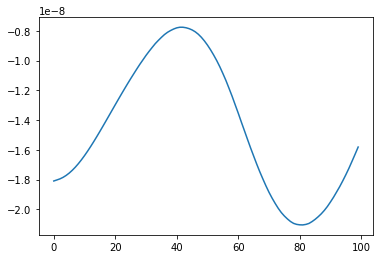

In [5]:
# plot phi_expectations
plt.plot(phi_expectations)
plt.show()

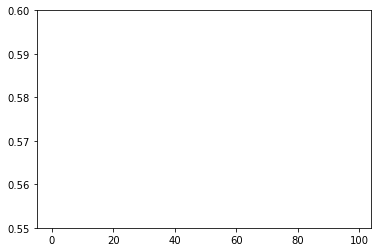

In [6]:
# plot energies
plt.plot(energy_t[:5000])
plt.ylim(0.55, 0.60)
plt.show()

In [7]:
# save psi_phi_t
np.save(f"data/psi_phi_t_m={m},g={g},l={l},kappa={kappa},phi_0={phi_0}.npy", psi_phi_t)